In [1]:
# 1. Imports and Setup

import sys, os
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(".."))
from notebook_setup import *
from src.evaluation import run_statistical_comparison
from src.visualization import plot_dm_results

tracker = ExperimentTracker()

Checking for crucial dependencies...
  -> Chronos: Available
  -> TimeGPT: Available
  -> API Key: Found
Notebook setup complete.


!!! SMOKE TEST ENABLED: Using last 200 points per series !!!
Dataset: M5 Walmart Hobbies Daily (5 Series) [SMOKE TEST]
Total: 200 | Train: 172 | Test: 28
Train: 2015-10-08 to 2016-03-27
Test: 2016-03-28 to 2016-04-24
Seasonal period: 7


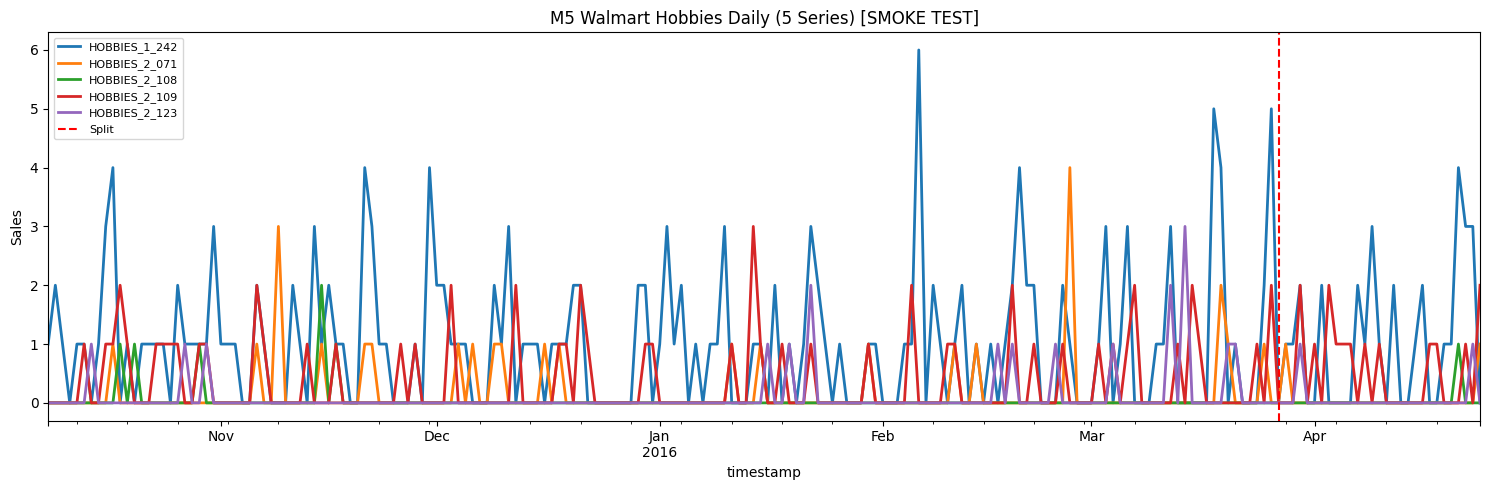

In [2]:
# 2. Data Loading and Configuration

# === DATASET CONFIGURATION ===
DATASET_CONFIG = {
    "file_path": "../datasets/m5_walmart_hobbies_daily.csv",
    "time_column": "timestamp",
    "target_column": "sales_count",
    "id_column": "unique_id",
    "future_covariates": ["wday", "month"],
    "past_covariates": ["snap_CA", "snap_TX", "snap_WI"],
    "static_covariates": ["unique_id"],
    "frequency": "D",
    "test_periods": 28,
    "seasonal_period": 7,
    "name": "M5 Walmart Hobbies Daily (5 Series)",
    "value_unit": "Sales",
}

# === LOAD AND PREPROCESS DATA ===
df = pd.read_csv(DATASET_CONFIG["file_path"])
df[DATASET_CONFIG["time_column"]] = pd.to_datetime(df[DATASET_CONFIG["time_column"]])
static_encoder = LabelEncoder()
df["unique_id_encoded"] = static_encoder.fit_transform(df[DATASET_CONFIG["id_column"]])

# Create Lists of Series
all_series, all_future_covs, all_past_covs = [], [], []
for uid in df[DATASET_CONFIG["id_column"]].unique():
    df_uid = df[df[DATASET_CONFIG["id_column"]] == uid].sort_values(
        DATASET_CONFIG["time_column"]
    )
    ts = TimeSeries.from_dataframe(
        df_uid,
        DATASET_CONFIG["time_column"],
        DATASET_CONFIG["target_column"],
        freq=DATASET_CONFIG["frequency"],
    ).astype(np.float32)

    static_covs = pd.DataFrame(
        {"unique_id": [uid], "unique_id_encoded": [df_uid["unique_id_encoded"].iloc[0]]}
    )
    ts = ts.with_static_covariates(static_covs)
    all_series.append(ts)

    if DATASET_CONFIG["future_covariates"]:
        all_future_covs.append(
            TimeSeries.from_dataframe(
                df_uid,
                DATASET_CONFIG["time_column"],
                DATASET_CONFIG["future_covariates"],
                freq=DATASET_CONFIG["frequency"],
            ).astype(np.float32)
        )
    if DATASET_CONFIG["past_covariates"]:
        all_past_covs.append(
            TimeSeries.from_dataframe(
                df_uid,
                DATASET_CONFIG["time_column"],
                DATASET_CONFIG["past_covariates"],
                freq=DATASET_CONFIG["frequency"],
            ).astype(np.float32)
        )

# === SMOKE TEST (Subset for faster tuning) ===
SMOKE_TEST = True
SMOKE_TEST_POINTS = 200

if SMOKE_TEST:
    smoke_msg = f"!!! SMOKE TEST ENABLED: Using last {SMOKE_TEST_POINTS} points per series !!!"
    print(smoke_msg)
    print("=" * len(smoke_msg))
    all_series = [s[-SMOKE_TEST_POINTS:] for s in all_series]
    if all_future_covs:
        all_future_covs = [c[-SMOKE_TEST_POINTS:] for c in all_future_covs]
    if all_past_covs:
        all_past_covs = [c[-SMOKE_TEST_POINTS:] for c in all_past_covs]

# Split
test_periods = DATASET_CONFIG["test_periods"]
split_time = pd.Timestamp(all_series[0].end_time()) - pd.DateOffset(days=test_periods)

train_series = [s.split_after(split_time)[0] for s in all_series]
test_series = [s.split_after(split_time)[1] for s in all_series]

# Covariates Split
train_future_covs = (
    [c.split_after(split_time)[0] for c in all_future_covs] if all_future_covs else None
)
train_past_covs = (
    [c.split_after(split_time)[0] for c in all_past_covs] if all_past_covs else None
)

# Scaling
target_scaler = Scaler()
train_scaled = target_scaler.fit_transform(train_series)

future_scaler = Scaler()
train_future_covs_scaled = (
    future_scaler.fit_transform(train_future_covs) if train_future_covs else None
)
all_future_covs_scaled = (
    future_scaler.transform(all_future_covs) if all_future_covs else None
)

past_scaler = Scaler()
train_past_covs_scaled = (
    past_scaler.fit_transform(train_past_covs) if train_past_covs else None
)
all_past_covs_scaled = past_scaler.transform(all_past_covs) if all_past_covs else None

# Static Covariates for Embeddings
static_cov_transformer = StaticCovariatesTransformer()
train_scaled = static_cov_transformer.fit_transform(train_scaled)

# Print Dataset Summary
print(f"Dataset: {DATASET_CONFIG['name']}" + (" [SMOKE TEST]" if SMOKE_TEST else ""))
print(f"Total: {len(all_series[0])} | Train: {len(train_series[0])} | Test: {len(test_series[0])}")
print(f"Train: {train_series[0].start_time().date()} to {train_series[0].end_time().date()}")
print(f"Test: {test_series[0].start_time().date()} to {test_series[0].end_time().date()}")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

# Visualize Train/Test Split for the all series
fig, ax = plt.subplots(figsize=(15, 5))
for i, s in enumerate(all_series):
    s.plot(ax=ax, label=f'{s.static_covariates["unique_id"].values[0]}')
ax.axvline(x=split_time, color='red', linestyle='--', label='Split')
ax.set_title(f'{DATASET_CONFIG["name"]}' + (' [SMOKE TEST]' if SMOKE_TEST else ''))
ax.set_ylabel(DATASET_CONFIG.get('value_unit', 'Value'))
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

In [3]:
# 3. Constants

SEASONAL_PERIOD = DATASET_CONFIG["seasonal_period"]
STAT_GRIDS = get_statistical_grids(SEASONAL_PERIOD)
DL_GRIDS = get_dl_grids(SEASONAL_PERIOD)

TEST_PERIODS = DATASET_CONFIG["test_periods"]

USE_FULL_GRID = TUNING_CONFIG["USE_FULL_GRID"]
N_ITER = TUNING_CONFIG["N_ITER"]

In [4]:
# 4. Statistical Models (LOCAL)

# Holt-Winters
run_tuning_local_and_eval(
    tracker,
    "Holt-Winters (LOCAL)",
    ExponentialSmoothing,
    STAT_GRIDS["Holt-Winters"],
    train_series,
    supports_covariates=False,
    seasonal_period=SEASONAL_PERIOD,
    test_periods=TEST_PERIODS,
)

# AutoARIMA
run_tuning_local_and_eval(
    tracker,
    "AutoARIMA (LOCAL)",
    AutoARIMA,
    STAT_GRIDS["AutoARIMA"],
    train_series,
    future_covs_list=all_future_covs,
    supports_covariates=True,
    seasonal_period=SEASONAL_PERIOD,
    test_periods=TEST_PERIODS,
)

# Prophet
run_tuning_local_and_eval(
    tracker,
    "Prophet (LOCAL)",
    Prophet,
    STAT_GRIDS["Prophet"],
    train_series,
    future_covs_list=all_future_covs,
    supports_covariates=True,
    seasonal_period=SEASONAL_PERIOD,
    test_periods=TEST_PERIODS,
)

Holt-Winters (LOCAL): 100%|██████████| 15/15 [00:04<00:00,  3.29it/s, best=0.28, rmse=0.32]


Holt-Winters (LOCAL): RMSE=0.2828 | MAPE=0.00% | Time=4.6s (15 combinations)


AutoARIMA (LOCAL): 100%|██████████| 1/1 [00:14<00:00, 14.90s/it, best=inf, rmse=0.30]


AutoARIMA (LOCAL): RMSE=0.2989 | MAPE=0.00% | Time=14.9s (1 combinations)


Prophet (LOCAL): 100%|██████████| 6/6 [00:31<00:00,  5.33s/it, best=0.26, rmse=0.42]

Prophet (LOCAL): RMSE=0.2557 | MAPE=0.00% | Time=32.0s (6 combinations)


{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01}

In [5]:
# 5. Deep Learning Models (GLOBAL)

# TiDE
run_tuning_global_and_eval(
    tracker,
    "TiDE (GLOBAL)",
    TiDEModel,
    DL_GRIDS["TiDE"],
    train_scaled,
    train_series,
    target_scaler,
    future_covs=train_future_covs_scaled,
    past_covs=train_past_covs_scaled,
    seasonal_period=SEASONAL_PERIOD,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    test_periods=TEST_PERIODS,
)

# N-BEATS
run_tuning_global_and_eval(
    tracker,
    "N-BEATS (GLOBAL)",
    NBEATSModel,
    DL_GRIDS["N-BEATS"],
    train_scaled,
    train_series,
    target_scaler,
    future_covs=None,
    past_covs=None,
    seasonal_period=SEASONAL_PERIOD,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    test_periods=TEST_PERIODS,
)

# TFT
run_tuning_global_and_eval(
    tracker,
    "TFT (GLOBAL)",
    TFTModel,
    DL_GRIDS["TFT"],
    train_scaled,
    train_series,
    target_scaler,
    future_covs=train_future_covs_scaled,
    past_covs=train_past_covs_scaled,
    seasonal_period=SEASONAL_PERIOD,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    test_periods=TEST_PERIODS,
)

TiDE (GLOBAL): 100%|██████████| 10/10 [01:25<00:00,  8.51s/it, best=0.24, rmse=0.49]


TiDE (GLOBAL): RMSE=0.2392 | MAPE=0.00% | Time=85.1s (10 combinations)


N-BEATS (GLOBAL): 100%|██████████| 10/10 [03:59<00:00, 23.98s/it, best=0.29, rmse=0.86]


N-BEATS (GLOBAL): RMSE=0.2889 | MAPE=0.00% | Time=239.8s (10 combinations)


TFT (GLOBAL): 100%|██████████| 10/10 [08:46<00:00, 52.63s/it, best=0.34, rmse=0.49]

TFT (GLOBAL): RMSE=0.3428 | MAPE=0.00% | Time=526.3s (10 combinations)


{'input_chunk_length': 7,
 'output_chunk_length': 7,
 'n_epochs': 30,
 'batch_size': 32,
 'random_state': 42,
 'hidden_size': 64,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [6]:
# 6. Foundation Models (Chronos, TimeGPT)

run_foundation_models(tracker, train_series, test_series, DATASET_CONFIG["frequency"])

Chronos: RMSE=0.7666 | MAPE=0.00% | Time=8.7s (1 combinations)
TimeGPT: RMSE=0.6695 | MAPE=0.00% | Time=2.5s (1 combinations)


In [7]:
# 7. Results Comparison (Cross-Validation Metrics)

results_df = tracker.get_results_df()
print("=== Cross-Validation Results ===")
print(
    results_df[["Model", "RMSE", "MAPE", "Tuning Time (s)", "Combinations"]].to_string(
        index=False
    )
)

=== Cross-Validation Results ===
               Model     RMSE  MAPE  Tuning Time (s)  Combinations
       TiDE (GLOBAL) 0.239157   0.0        85.145402            10
     Prophet (LOCAL) 0.255658   0.0        31.963399             6
Holt-Winters (LOCAL) 0.282847   0.0         4.561299            15
    N-BEATS (GLOBAL) 0.288924   0.0       239.779047            10
   AutoARIMA (LOCAL) 0.298950   0.0        14.907662             1
        TFT (GLOBAL) 0.342757   0.0       526.296855            10
             TimeGPT 0.669458   0.0         2.505899             1
             Chronos 0.766632   0.0         8.675793             1


In [8]:
# 8. Train Final Predictions for ALL Models (for Statistical Comparison)

# Get list of all models that successfully ran
all_models = tracker.get_results_df()["Model"].tolist()

final_preds = get_final_predictions(
    tracker,
    train_series,
    test_series,
    target_scaler,
    train_scaled,
    DATASET_CONFIG["frequency"],
    future_covs=all_future_covs,
    train_future_covs_scaled=train_future_covs_scaled,
    train_past_covs_scaled=train_past_covs_scaled,
    all_future_covs_scaled=all_future_covs_scaled,
    all_past_covs_scaled=all_past_covs_scaled,
    models_to_predict=all_models
)

Retraining TiDE (GLOBAL)...


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Retraining Prophet (LOCAL)...
Retraining Holt-Winters (LOCAL)...
Retraining N-BEATS (GLOBAL)...


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Retraining AutoARIMA (LOCAL)...
Retraining TFT (GLOBAL)...


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Retraining TimeGPT...
Retraining Chronos...


In [9]:
# 8b. Statistical Significance Testing (Diebold-Mariano Test)

# Run statistical comparison (using h=test_periods for daily data with sufficient samples)
# Note: For multiseries, the test will flatten all series into one large sample.
dm_results_df = run_statistical_comparison(
    tracker, 
    final_preds, 
    test_series, 
    h=DATASET_CONFIG["test_periods"]
)

# Visualize Results as Table
fig_dm = plot_dm_results(dm_results_df, DATASET_CONFIG["name"])
if fig_dm:
    fig_dm.show()

In [10]:
# 9. Visualize Final Predictions with Best and Fastest Models (Interactive)

for i in range(len(train_series)):
    fig = plot_forecast_comparison(
        train_series,
        test_series,
        final_preds,
        DATASET_CONFIG["name"],
        DATASET_CONFIG.get("target_column"),
        DATASET_CONFIG.get("value_unit"),
        series_idx=i,
    )
    if fig:
        fig.show()
    else:
        print(f"No predictions to visualize for series {i}.")

In [11]:
# 10. Model Comparison Chart (Interactive)

fig_comp = plot_model_comparison(
    tracker.get_results_df(),
    DATASET_CONFIG["name"],
    value_unit=DATASET_CONFIG.get("value_unit"),
    plot_mape=False,
    test_predictions=final_preds
)
fig_comp.show()

In [13]:
# 11. Export Static PNG Images

for i in range(len(train_series)):
    fig = plot_forecast_comparison(
        train_series, test_series, final_preds, DATASET_CONFIG["name"], series_idx=i
    )
    sid = train_series[i].static_covariates["unique_id"].values[0]
    export_plots(fig, None, DATASET_CONFIG["name"], suffix=sid)

export_plots(None, fig_comp, DATASET_CONFIG["name"], fig_dm=fig_dm if 'fig_dm' in locals() else None)